In [104]:
#python 2/3 compatibility
from __future__ import absolute_import, division, print_function, unicode_literals
#packages
import pathlib
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import seaborn as sns
#set graphs to plot within env
%matplotlib inline
#set style of graphs
sns.set(rc={'figure.figsize':(12, 6)})
plt.style.use('fivethirtyeight')

In [4]:
#add code to input data
#for now, uploads data file from local drive
#synthetic dataset constructed of cleaveland and cincinnati
dataset = pd.read_csv('synthetic_dataComboDF.csv')

In [539]:
#preview the dataset, uncomment to run
#dataset.head()

In [214]:
#convert all features to integers
dataset = dataset.astype(int).copy()

In [540]:
#view dist + corr of all features, uncomment to run
#sns.pairplot(dataset[['SF', 'Floors','Year Built', 'Value', 'E annual', 'G annual']], diag_kind="kde")

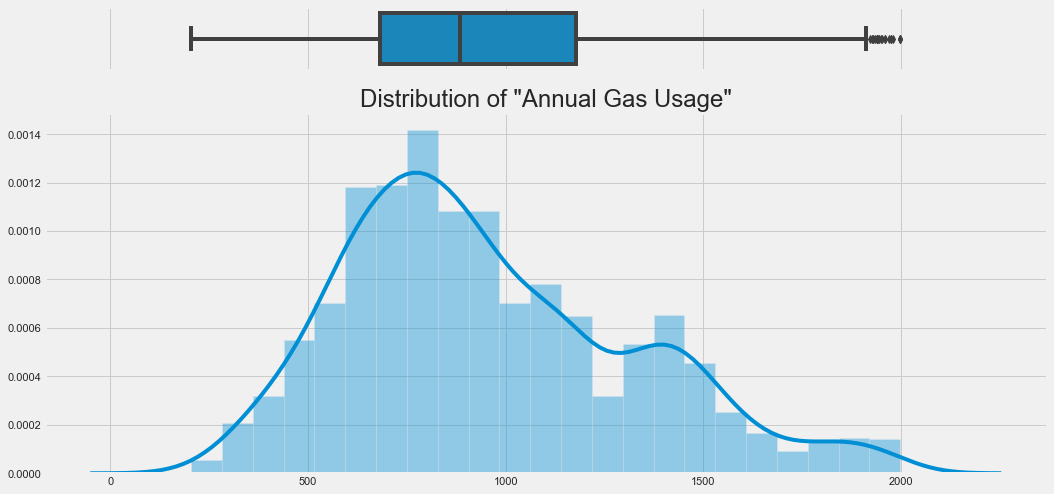

In [600]:
#view the target feature gas specifically to ID outliers and dist.
#uncommet to run
#fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
#sns.boxplot(dataset['G annual'], ax=boxplot)
#sns.distplot(dataset['G annual'], ax=histogram)
#boxplot.set(xlabel='')
#plt.title('Distribution of "Annual Gas Usage"', fontsize=24)
#plt.xlabel('');

In [217]:
#set gas value less than 2000 Annual value to remove long tail skew to the right
dataset = dataset[dataset['G annual'] <= 2000].copy()

In [601]:
#set gas value about 500 annual
dataset = dataset[dataset['G annual'] >= 500].copy()

In [602]:
#view transposed training data
train_DF = dataset.describe()
train_DF = train_DF.transpose()
#uncommet to view
#train_DF

In [221]:
#drop estimated savings feature to eliminate from input data
dataset.drop('Estimated Savings', axis=1, inplace=True)

In [603]:
#sample dataset (10% of full data) to test parameter tuning with
#uncomment to run
#dataset = dataset.sample(frac=0.1, random_state=0)

In [604]:
#split data into train/test sets 80%/20%
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [605]:
#creates training data stats 
train_stats = train_dataset.describe()
train_stats.pop("G annual")
train_stats = train_stats.transpose()

#save train stats for norm. function
scaler_filename = "trainPredGasScalerV2.save"
joblib.dump(train_stats, scaler_filename)

['trainPredGasScalerV2.save']

In [606]:
#creates train and test datasets target variable: Annual Natural Gas Usage
#and removes target variable from feature variable dataset
train_labels = train_dataset.pop('G annual')
test_labels = test_dataset.pop('G annual')

In [607]:
#Function to normalize train and test datasets to dist. range from train data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [608]:
#normalized train and test datasets
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

---DEEP LEARNING MODEL FRAMEWORK---

In [609]:
#Deep Learning model, can adjust optimizer by commenting/uncommeting 'optimizer' variable
#loss func. set to highly penalize model for large errors
#uncomment layers to adjust model depth
#uncomment dropouts as needed between layers to reduce overfitting

def build_model():
  model = keras.Sequential([
    #layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    #layers.Dropout(0.20),
    #layers.Dense(256, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.25),
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.25),
    #layers.Dense(16, activation='relu'),
    #layers.Dropout(0.20),
    #layers.Dense(8, activation='relu'),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
  optimizer = tf.keras.optimizers.Adam(lr=0.001)

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [610]:
#calls ML model and assigns it to the variable 'model'
model = build_model()

---TESTING/FINE-TUNING USE CODE BELOW---

In [543]:
#runs the above model for a set number of epochs

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1520,  mae:284.0862,  mse:132504.0312,  val_loss:0.1500,  val_mae:275.7911,  val_mse:131202.2031,  
....................................................................................................
Epoch: 100, loss:0.1481,  mae:279.5543,  mse:129677.8516,  val_loss:0.1543,  val_mae:279.7677,  val_mse:131329.7188,  
....................................................................................................
Epoch: 200, loss:0.1472,  mae:277.8206,  mse:129921.1328,  val_loss:0.1543,  val_mae:276.7741,  val_mse:134072.1094,  
....................................................................................................
Epoch: 300, loss:0.1441,  mae:274.2654,  mse:124943.4297,  val_loss:0.1551,  val_mae:277.3610,  val_mse:133625.7031,  
....................................................................................................
Epoch: 400, loss:0.1423,  mae:272.0574,  mse:124515.9922,  val_loss:0.1540,  val_mae:277.0667,  val_mse:130443.6719,  
..

In [545]:
#shows last 5 epochs metrics of loss
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.131073,257.913757,115368.648438,0.156933,284.010803,131667.187500,995
996,0.131688,258.960999,115243.203125,0.159765,286.606689,134256.203125,996
997,0.131034,258.211121,114983.937500,0.156638,284.817627,132042.078125,997
998,0.130513,257.864899,114607.312500,0.158241,282.171478,134479.656250,998
999,0.130684,258.032257,114139.804688,0.155689,278.752228,134384.078125,999


In [546]:
#set plot with a smoothing parameter
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Est. Gas Usage]')

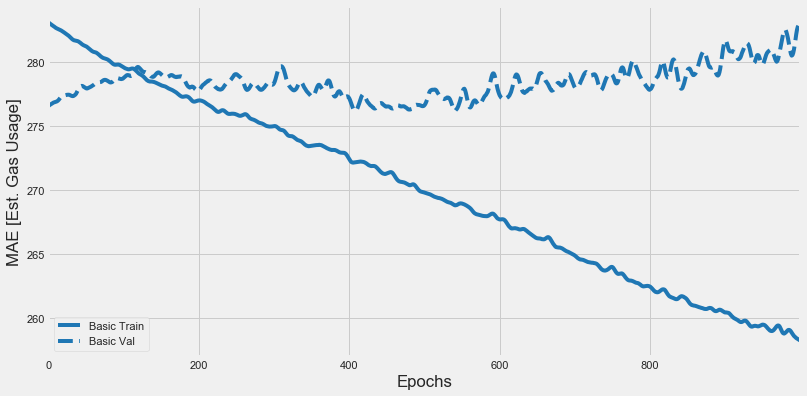

In [547]:
#Plots Mean Absolute Error
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Est. Gas Usage]')

Text(0, 0.5, 'MSE [Est. Savings^2]')

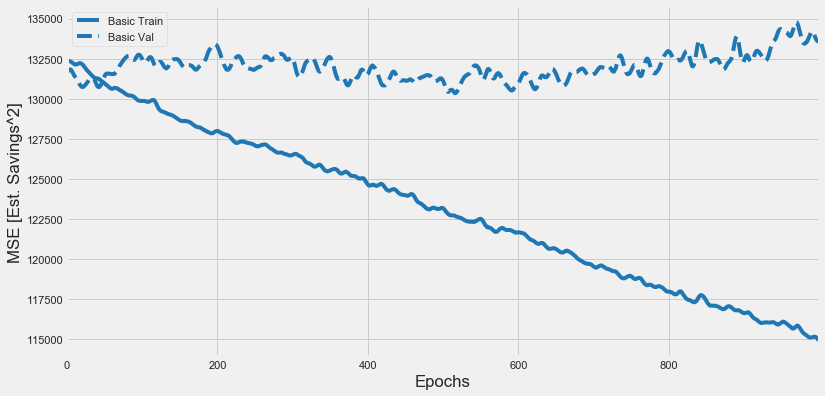

In [548]:
#Plots Mean Squared Error
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [Est. Savings^2]')

In [549]:
#Test/train with an early stopping parameter to prevent overfitting

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:37.7586,  mae:948.1652,  mse:1032388.4375,  val_loss:28.9091,  val_mae:943.1813,  val_mse:1018012.5625,  
....................................................................................................
Epoch: 100, loss:0.1630,  mae:294.8510,  mse:141789.0781,  val_loss:0.1486,  val_mae:273.3709,  val_mse:129796.8828,  
....................................................................................................
Epoch: 200, loss:0.1575,  mae:289.6741,  mse:139497.8281,  val_loss:0.1479,  val_mae:275.3886,  val_mse:128518.6953,  
....................................................................................................
Epoch: 300, loss:0.1557,  mae:287.8746,  mse:136056.3438,  val_loss:0.1472,  val_mae:274.3257,  val_mse:129085.2891,  
............................................................................

Text(0, 0.5, 'MAE [Est. Savings]')

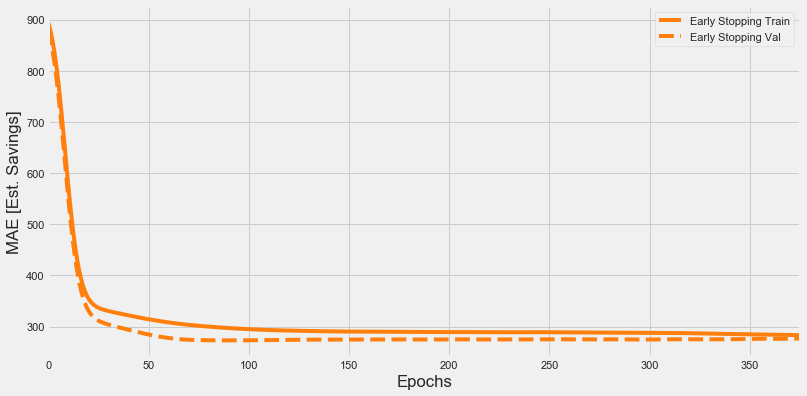

In [550]:
#plots Mean Absolute Error for the early stopping model
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [Est. Savings]')

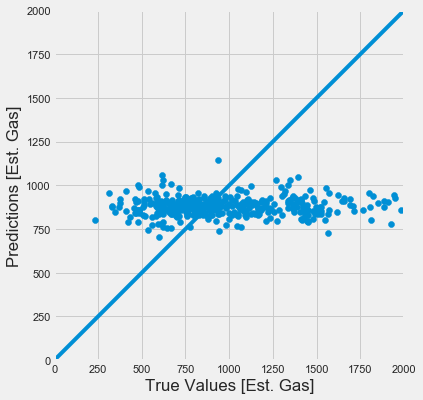

In [551]:
#plots predictions versus truth values
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Est. Gas]')
plt.ylabel('Predictions [Est. Gas]')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

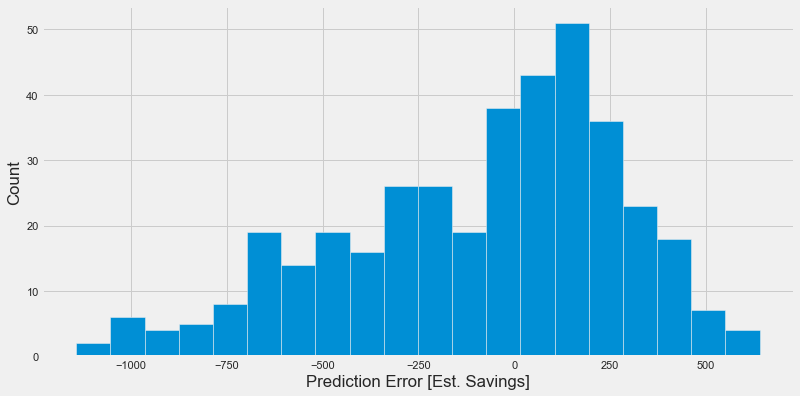

In [552]:
#dist. of errors by number of errors and diff. between predict and actual value
error = test_predictions - test_labels
plt.hist(error, bins = 20)
plt.xlabel("Prediction Error [Est. Savings]")
_ = plt.ylabel("Count")

In [553]:
#prints the metrics for the best epoch of the trained model
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} Est. Gas Usage".format(mae))

384/384 - 0s - loss: 0.1517 - mae: 296.2058 - mse: 143324.9531
Testing set Mean Abs Error: 296.21 Est. Gas Usage


---TO TRAIN AND SAVE A MODEL RUN BELOW---

In [611]:
#The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=100, restore_best_weights=True)

model.fit(normed_train_data, train_labels, epochs=1000, 
          validation_split = 0.2, verbose=0, 
          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:41.1311,  mae:1003.4373,  mse:1126360.5000,  val_loss:32.9120,  val_mae:988.4562,  val_mse:1100895.8750,  
....................................................................................................
Epoch: 100, loss:0.1169,  mae:280.0701,  mse:127973.1641,  val_loss:0.1193,  val_mae:284.2418,  val_mse:131278.2188,  
....................................................................................................
Epoch: 200, loss:0.1085,  mae:272.7751,  mse:120521.4062,  val_loss:0.1172,  val_mae:284.7126,  val_mse:128787.3203,  
....................................................................................................
Epoch: 300, loss:0.1078,  mae:272.9958,  mse:118823.0312,  val_loss:0.1177,  val_mae:283.9671,  val_mse:131257.6406,  
....................................................................................................
Epoch: 400, loss:0.1039,  mae:266.2484,  mse:116206.0703,  val_loss:0.1203,  val_mae:288.9889,  val_mse:131383.5469,

In [612]:
#check models loss, mean actual error rate, mean squared error rate
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

353/353 - 0s - loss: 0.1077 - mae: 260.8113 - mse: 109508.5703
Testing set Mean Abs Error: 260.81 


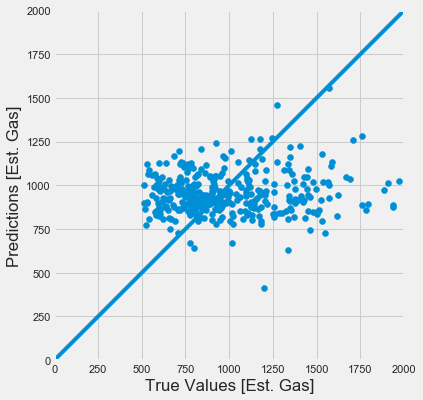

In [613]:
#plots predictions versus truth values
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Est. Gas]')
plt.ylabel('Predictions [Est. Gas]')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

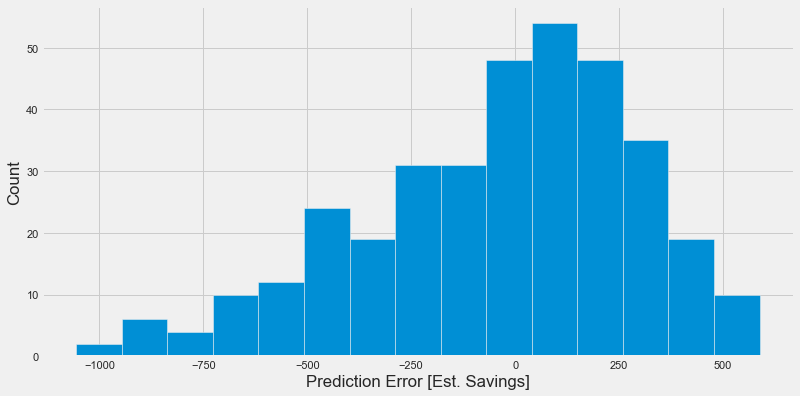

In [619]:
#dist. of errors by number of errors and diff. between predict and actual value
error = test_predictions - test_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [Est. Savings]")
_ = plt.ylabel("Count")

In [620]:
#saves TF model as name noted below
model.save('predAnnualGas.h5')

In [621]:
#Save the model, serialized model to JSON format
model_json = model.to_json()
with open("predGasModel.json", "w") as json_file:
    json_file.write(model_json)